In [0]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from PIL import Image
import requests
import os

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, utils, datasets, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg16, inception_v3

tf.random.set_seed(17)

TensorFlow 2.x selected.


In [3]:
!rm -rf cousteau
!git clone https://github.com/datawookie/cousteau.git
  
from cousteau.keras.plot import plot_history

Cloning into 'cousteau'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
Unpacking objects: 100% (18/18), done.
remote: Total 18 (delta 6), reused 16 (delta 4), pack-reused 0


In [4]:
!rm -rf car-dataset # allows us to re-clone the dataset w/ updates and get the changes - if folder exists, clone does not work and we won't get anychanges
!git clone https://github.com/GerardWalsh/car-dataset.git

Cloning into 'car-dataset'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (572/572), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 572 (delta 94), reused 534 (delta 61), pack-reused 0
Receiving objects: 100% (572/572), 26.95 MiB | 41.07 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [0]:
image_paths = list(paths.list_images("car-dataset/train"))

images = []
labels = []

for path in image_paths:
  img = preprocessing.image.load_img(path, target_size=(224, 224))
  img = np.expand_dims(img, axis=0)
  
  images.append(img)

  label = path.split(os.path.sep)[-2]
  if label == "7_5":
    label = 0
  elif label == "7":
    label = 1
  elif label == '6':
    label = 2
  else: 
    label = 3
  labels.append(label)

In [6]:
from collections import Counter
Counter(labels).keys()

dict_keys([3, 2, 1, 0])

In [7]:
Counter(labels).values()

dict_values([60, 89, 83, 68])

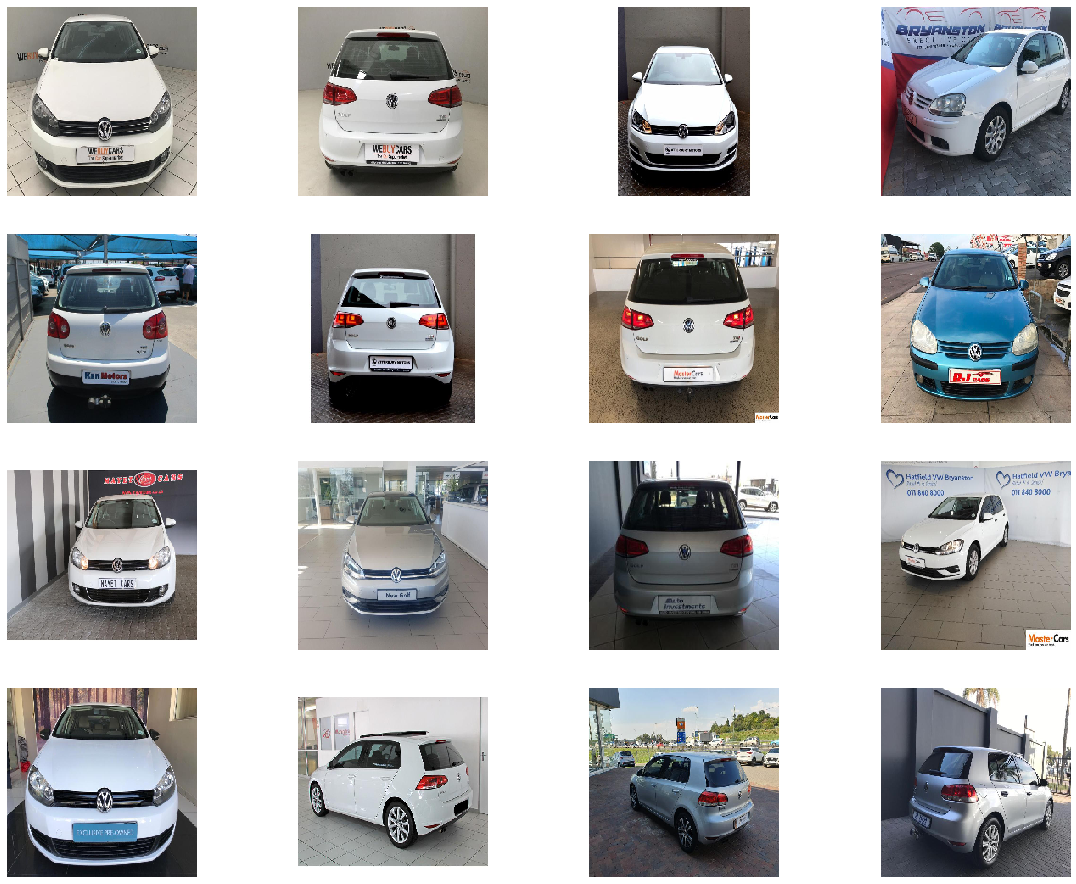

In [8]:
fig = plt.figure(figsize = (20, 16))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))

plt.show()

In [0]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
def augment_image(image, replicates=4):
    images = [image]
    i = 1
    for batch in datagen.flow(image, batch_size=1):
        images.append(batch)
        i += 1
        if i >= replicates:
            break
    return images

In [0]:
REPLICATES = 4

In [0]:
images = [augment_image(image, REPLICATES) for image in images]

In [0]:
images = [image for sublist in images for image in sublist]

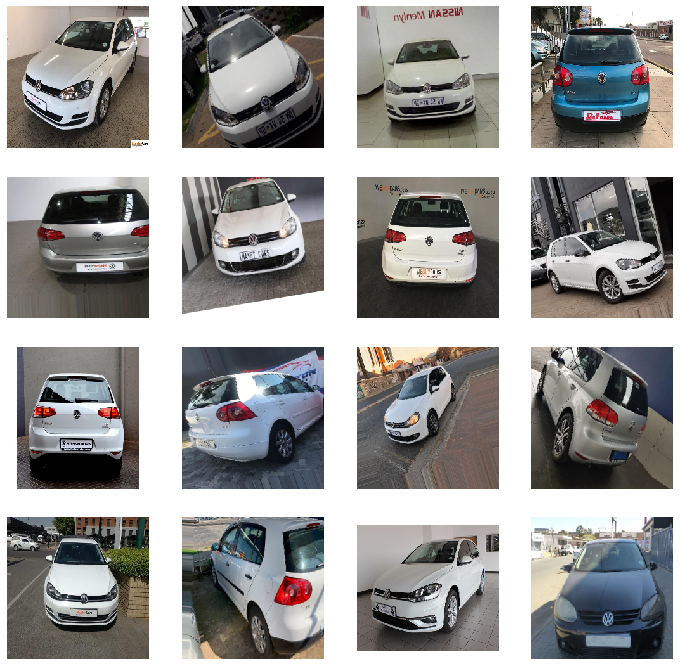

In [14]:
fig = plt.figure(figsize = (12, 12))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  # Transformations result in float32, so cast to uint8.
  plt.imshow(np.squeeze(img).astype('uint8'))

plt.show()

In [0]:
labez = [[label] * REPLICATES for label in labels]

In [0]:
labelz = np.array([label for sublist in labez for label in sublist])

In [17]:
print('Image count (after transform): {}'.format(len(images)), '\n', 'Label count (after transform): {}'.format(len(labelz)))

Image count (after transform): 1200 
 Label count (after transform): 1200


In [0]:
images = np.concatenate(images)

In [0]:
input_shape = images.shape[1:]

In [0]:
images = resnet.preprocess_input(images)

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labelz, test_size=0.2, random_state=13)

In [22]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

Using TensorFlow backend.


# Shallow CNN

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=3, activation = 'relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Conv2D(64, kernel_size=3, activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size=2))      

model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, activation = 'softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               23888000  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [0]:
batch_size = 32
epochs = 20

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/20
768/768 [==============================] - 9s 12ms/sample - loss: 1.6913 - accuracy: 0.3932 - val_loss: 6.2629 - val_accuracy: 0.3073
Epoch 2/20
768/768 [==============================] - 1s 2ms/sample - loss: 1.1245 - accuracy: 0.5521 - val_loss: 3.1191 - val_accuracy: 0.3438
Epoch 3/20
768/768 [==============================] - 1s 2ms/sample - loss: 0.7941 - accuracy: 0.6771 - val_loss: 2.1189 - val_accuracy: 0.3802
Epoch 4/20
768/768 [==============================] - 1s 2ms/sample - loss: 0.5517 - accuracy: 0.8021 - val_loss: 1.5510 - val_accuracy: 0.4323
Epoch 5/20
768/768 [==============================] - 1s 2ms/sample - loss: 0.2527 - accuracy: 0.9219 - val_loss: 1.2954 - val_accuracy: 0.4844
Epoch 6/20
768/768 [==============================] - 1s 2ms/sample - loss: 0.1780 - accuracy: 0.9531 - val_loss: 1.5044 - val_accuracy: 0.4219
Epoch 7/20
768/768 [==============================] - 1s 2ms/sample - loss: 0.1013 - accu

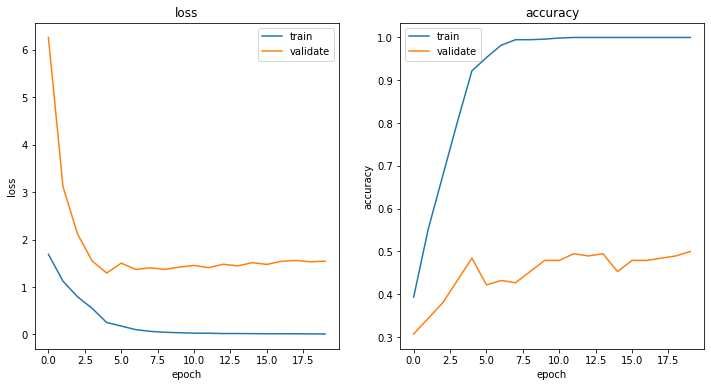

In [28]:
plot_history(history)

In [29]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0110 - accuracy: 0.9987 - val_loss: 1.6605 - val_accuracy: 0.5208
Epoch 2/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0100 - accuracy: 1.0000 - val_loss: 1.6185 - val_accuracy: 0.4948
Epoch 3/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0091 - accuracy: 1.0000 - val_loss: 1.6872 - val_accuracy: 0.5000
Epoch 4/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0091 - accuracy: 1.0000 - val_loss: 1.6242 - val_accuracy: 0.4844
Epoch 5/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.6899 - val_accuracy: 0.4792
Epoch 6/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0091 - accuracy: 1.0000 - val_loss: 1.6363 - val_accuracy: 0.4844
Epoch 7/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0088 - accur

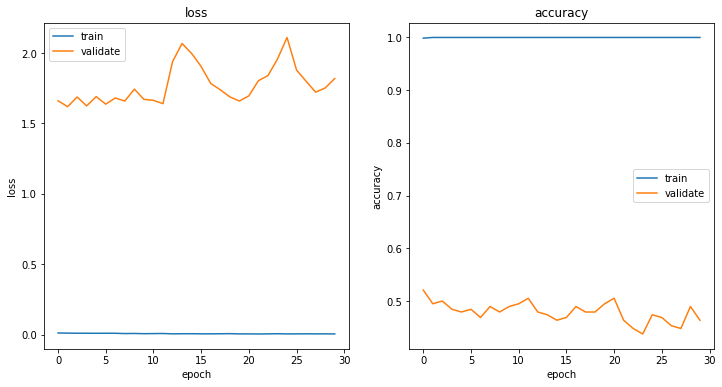

In [30]:
plot_history(history)

In [31]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 52.50% 
Test loss     = 1.548864


## Summary 
Our simple model has stopped learning from the data, as the accuracy is not increasing and our training accuracy is nearly 100%, and will only overfit the data with more training. A more complex model is required - a 3-class accuracy of ~55% is not desireable. 

# Complex model 

In [32]:
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

94773248/94765736 [==============================] - 1s 0us/step


In [33]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
base_model.trainable = True

In [0]:
resnet50 = models.Sequential()

resnet50.add(base_model)
resnet50.add(layers.Flatten())
resnet50.add(layers.Dense(16, activation='relu'))
resnet50.add(layers.BatchNormalization())
resnet50.add(layers.Dropout(0.5))
resnet50.add(layers.Dense(4, activation='softmax'))

In [36]:
resnet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 25,193,492
Trainable params: 25,140,340
Non-trainable params: 53,152
_____________________________________

In [0]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-5),
    metrics=['accuracy']
)

In [38]:
history = resnet50.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=120,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/120
768/768 [==============================] - 17s 21ms/sample - loss: 2.0585 - accuracy: 0.3307 - val_loss: 1.8958 - val_accuracy: 0.3594
Epoch 2/120
768/768 [==============================] - 8s 11ms/sample - loss: 1.3399 - accuracy: 0.4674 - val_loss: 1.3598 - val_accuracy: 0.4583
Epoch 3/120
768/768 [==============================] - 8s 11ms/sample - loss: 0.9565 - accuracy: 0.6094 - val_loss: 1.0278 - val_accuracy: 0.5833
Epoch 4/120
768/768 [==============================] - 8s 11ms/sample - loss: 0.7351 - accuracy: 0.6862 - val_loss: 0.9240 - val_accuracy: 0.6302
Epoch 5/120
768/768 [==============================] - 8s 11ms/sample - loss: 0.6253 - accuracy: 0.7578 - val_loss: 0.8651 - val_accuracy: 0.6615
Epoch 6/120
768/768 [==============================] - 8s 11ms/sample - loss: 0.5358 - accuracy: 0.7930 - val_loss: 0.8132 - val_accuracy: 0.6719
Epoch 7/120
768/768 [==============================] - 8s 11ms/sample - loss:

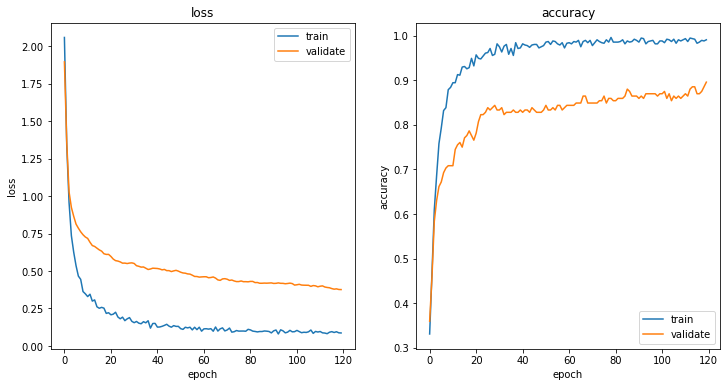

In [39]:
plot_history(history)

In [40]:
history = resnet50.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/20
768/768 [==============================] - 8s 11ms/sample - loss: 0.0915 - accuracy: 0.9870 - val_loss: 0.3805 - val_accuracy: 0.8906
Epoch 2/20
768/768 [==============================] - 8s 11ms/sample - loss: 0.0920 - accuracy: 0.9883 - val_loss: 0.3748 - val_accuracy: 0.8854
Epoch 3/20
768/768 [==============================] - 8s 11ms/sample - loss: 0.0763 - accuracy: 0.9935 - val_loss: 0.3719 - val_accuracy: 0.8906
Epoch 4/20
768/768 [==============================] - 8s 11ms/sample - loss: 0.0850 - accuracy: 0.9922 - val_loss: 0.3771 - val_accuracy: 0.8854
Epoch 5/20
768/768 [==============================] - 8s 11ms/sample - loss: 0.0930 - accuracy: 0.9948 - val_loss: 0.3743 - val_accuracy: 0.8854
Epoch 6/20
768/768 [==============================] - 8s 11ms/sample - loss: 0.0845 - accuracy: 0.9974 - val_loss: 0.3766 - val_accuracy: 0.8906
Epoch 7/20
768/768 [==============================] - 8s 11ms/sample - loss: 0.0881 

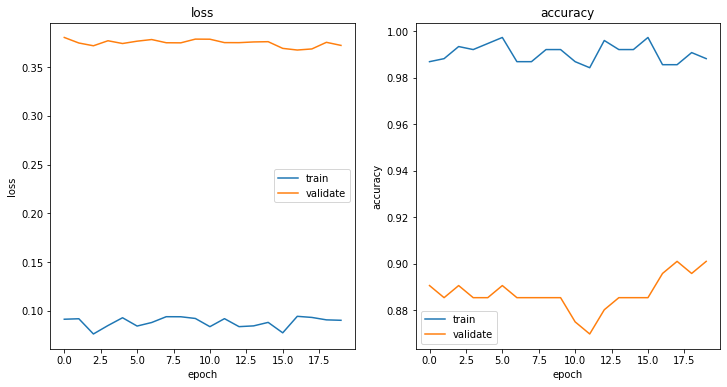

In [41]:
plot_history(history)

In [42]:
score = resnet50.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 87.92% 
Test loss     = 0.396533


## Summary
Resnet50 fits the data relatively well, at 86% accuracy for a 3-class classifaction problem on our test set - could we utilize transfer learning to get a higher accuracy and achieve say 90% accuracy, with our limited data?

# Transfer learning 


In [0]:
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

In [0]:
def build_resnet():
  resnet_model = models.Sequential()

  resnet_model.add(base_model)
  resnet_model.add(layers.Flatten())
  resnet_model.add(layers.Dense(1028, activation='relu'))
  resnet_model.add(layers.BatchNormalization())
  resnet_model.add(layers.Dropout(0.5))
  resnet_model.add(layers.Dense(16, activation='relu'))
  resnet_model.add(layers.BatchNormalization())
  resnet_model.add(layers.Dropout(0.5))
  resnet_model.add(layers.Dense(4, activation='softmax'))

  return resnet_model 

resnet50_tl = build_resnet()

In [45]:
def trainable_weights(model):
  return sum([int(tf.size(weights)) for weights in model.trainable_weights])

# How many trainable weights in the base model?
trainable_weights(base_model)

23534592

In [0]:
base_model.trainable = False

In [47]:
trainable_weights(base_model)

0

### Important
This is the crucial step - here we are forcing the convolutional kernels (base model) to keep their weights obtained from training on ImageNet and train only our Fully Connected layers (the classifier). 

In [48]:
resnet50_tl.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1028)              103162884 
_________________________________________________________________
batch_normalization_2 (Batch (None, 1028)              4112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1028)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                16464     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)               

In [0]:
resnet50_tl.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-3),
    metrics=['accuracy']
)

Since we are only determining weights for our classifier, not the convolutional kernels, we can train for much less epochs. 

In [50]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/30
768/768 [==============================] - 8s 10ms/sample - loss: 1.5063 - accuracy: 0.4388 - val_loss: 4.1093 - val_accuracy: 0.4948
Epoch 2/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.8551 - accuracy: 0.6589 - val_loss: 1.1838 - val_accuracy: 0.5885
Epoch 3/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.5877 - accuracy: 0.7812 - val_loss: 0.9502 - val_accuracy: 0.6823
Epoch 4/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.5022 - accuracy: 0.8151 - val_loss: 0.8592 - val_accuracy: 0.6615
Epoch 5/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.3980 - accuracy: 0.8594 - val_loss: 0.8754 - val_accuracy: 0.6615
Epoch 6/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.3385 - accuracy: 0.8958 - val_loss: 0.8121 - val_accuracy: 0.6771
Epoch 7/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.2817 - accu

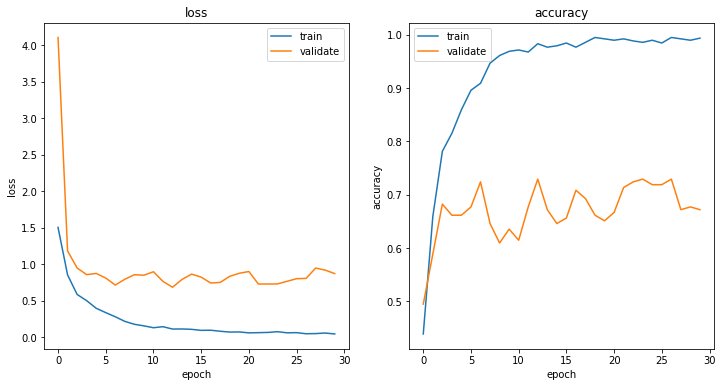

In [51]:
plot_history(history)

In [52]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 70.42% 
Test loss     = 0.810502


# Overfitting
We are overfitting our model to our data - our validation accuracy is much lower than our training accuracy. Let's try use soft label assignments for our training labels to attempt to decrease overfitting. 

In [0]:
resnet50_tl = build_resnet()
base_model.trainable = False

In [54]:
# Check that we are using the pre-trained convolutional kernels
trainable_weights(base_model)

0

In [0]:
from tensorflow.keras.losses import CategoricalCrossentropy
loss = CategoricalCrossentropy(label_smoothing=0.1)

### Important
This is a step towards decreasing over-fitting. Keras/Tensorflow has a soft labelling class that we can utilize directly. 

In [0]:
resnet50_tl.compile(
    loss=loss,
    optimizer=optimizers.Adam(lr=1e-02),
    metrics=['accuracy']
)

In [57]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/30
768/768 [==============================] - 7s 9ms/sample - loss: 1.5243 - accuracy: 0.4010 - val_loss: 4.3970 - val_accuracy: 0.5208
Epoch 2/30
768/768 [==============================] - 4s 5ms/sample - loss: 1.0658 - accuracy: 0.5807 - val_loss: 1.6713 - val_accuracy: 0.4688
Epoch 3/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.8734 - accuracy: 0.7357 - val_loss: 1.0710 - val_accuracy: 0.5885
Epoch 4/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.7074 - accuracy: 0.8372 - val_loss: 1.0318 - val_accuracy: 0.6094
Epoch 5/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.5959 - accuracy: 0.9102 - val_loss: 1.4486 - val_accuracy: 0.5208
Epoch 6/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.5495 - accuracy: 0.9492 - val_loss: 1.1249 - val_accuracy: 0.6302
Epoch 7/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.5180 - accur

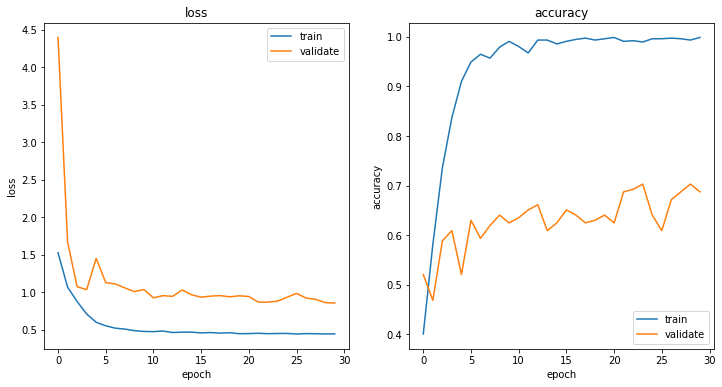

In [58]:
plot_history(history)

In [59]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 69.17% 
Test loss     = 0.863128


## Hyperparameter tuning
Our training heuristics are unstable - let's try a lower learning rate. Transfer learning is promising though, since we achieved 77% accuracy on our test set after only 30 epochs - a feat which took our previous training attempt 120 epochs. 

In [0]:
resnet50_tl = build_resnet()

In [61]:
trainable_weights(base_model)

0

In [0]:
resnet50_tl.compile(
    loss=loss,
    optimizer=optimizers.Adam(lr=1e-2),
    metrics=['accuracy']
)

In [63]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 7s 9ms/sample - loss: 1.4789 - accuracy: 0.3919 - val_loss: 6.8124 - val_accuracy: 0.4167
Epoch 2/10
768/768 [==============================] - 4s 5ms/sample - loss: 1.0743 - accuracy: 0.5990 - val_loss: 1.9225 - val_accuracy: 0.4896
Epoch 3/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.8720 - accuracy: 0.7422 - val_loss: 1.1964 - val_accuracy: 0.5521
Epoch 4/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.6744 - accuracy: 0.8581 - val_loss: 1.6561 - val_accuracy: 0.4062
Epoch 5/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.5871 - accuracy: 0.9193 - val_loss: 1.7461 - val_accuracy: 0.4948
Epoch 6/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.5289 - accuracy: 0.9466 - val_loss: 1.1325 - val_accuracy: 0.6458
Epoch 7/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.5040 - accur

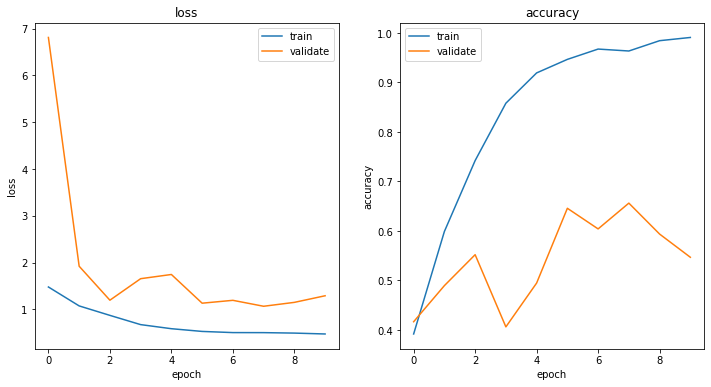

In [64]:
plot_history(history)

In [65]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 52.08% 
Test loss     = 1.247235


# Is there more?

In [66]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4687 - accuracy: 0.9870 - val_loss: 1.1582 - val_accuracy: 0.5573
Epoch 2/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4613 - accuracy: 0.9909 - val_loss: 1.0421 - val_accuracy: 0.6198
Epoch 3/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4551 - accuracy: 0.9974 - val_loss: 0.9965 - val_accuracy: 0.6250
Epoch 4/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4653 - accuracy: 0.9844 - val_loss: 0.9372 - val_accuracy: 0.6615
Epoch 5/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4652 - accuracy: 0.9844 - val_loss: 0.9938 - val_accuracy: 0.6302
Epoch 6/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4581 - accuracy: 0.9883 - val_loss: 0.9764 - val_accuracy: 0.6094
Epoch 7/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4609 - accur

In [67]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 66.25% 
Test loss     = 0.906686


## Summary
Utilizing the resnet50 backbone (feature extractor), we managaed to score 76% accuracy on our test set which is similar to our model that trained resnet50 from scratch, convolutional kernels and all. Can we push that classification accuracy higher by updating some of the kernel weights?

# Fine tune ResNet50

In [68]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [69]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [70]:
# How many trainable weights in the base model?
trainable_weights(base_model)

0

In [71]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

23534592

In [0]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[171:174]:
   layer.trainable = True
    
# How many trainable weights in the base model?
# trainable_weights(base_model)
# Check that this agrees with the model summary.

In [0]:
resnet50_tl.compile(
    loss=loss,
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

In [74]:
resnet50_tl.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 1028)              103162884 
_________________________________________________________________
batch_normalization_6 (Batch (None, 1028)              4112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1028)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                16464     
_________________________________________________________________
batch_normalization_7 (Batch (None, 16)               

In [75]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/50
768/768 [==============================] - 8s 10ms/sample - loss: 0.4332 - accuracy: 0.9974 - val_loss: 0.9322 - val_accuracy: 0.6406
Epoch 2/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4302 - accuracy: 0.9961 - val_loss: 0.9117 - val_accuracy: 0.6615
Epoch 3/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4272 - accuracy: 0.9987 - val_loss: 0.9070 - val_accuracy: 0.6615
Epoch 4/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4267 - accuracy: 0.9987 - val_loss: 0.8866 - val_accuracy: 0.6615
Epoch 5/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4315 - accuracy: 0.9974 - val_loss: 0.8909 - val_accuracy: 0.6667
Epoch 6/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4269 - accuracy: 0.9974 - val_loss: 0.8852 - val_accuracy: 0.6615
Epoch 7/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4349 - accu

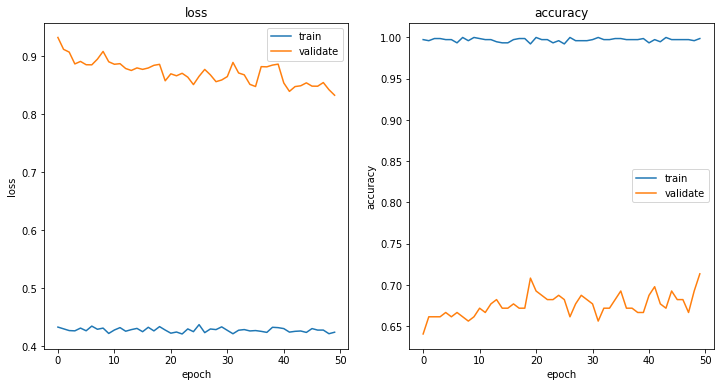

In [76]:
plot_history(history)

In [77]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4289 - accuracy: 0.9935 - val_loss: 0.8336 - val_accuracy: 0.7083
Epoch 2/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4232 - accuracy: 0.9987 - val_loss: 0.8294 - val_accuracy: 0.7083
Epoch 3/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4196 - accuracy: 1.0000 - val_loss: 0.8214 - val_accuracy: 0.7240
Epoch 4/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4248 - accuracy: 0.9987 - val_loss: 0.8262 - val_accuracy: 0.7083
Epoch 5/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4221 - accuracy: 1.0000 - val_loss: 0.8350 - val_accuracy: 0.7031
Epoch 6/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4234 - accuracy: 0.9961 - val_loss: 0.8322 - val_accuracy: 0.7083
Epoch 7/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4239 - accur

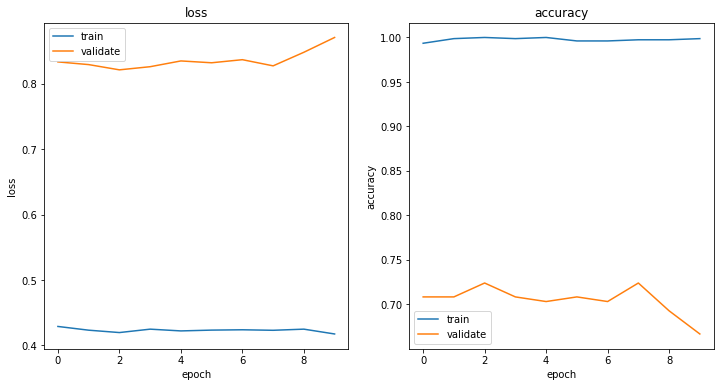

In [78]:
plot_history(history)

In [79]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 52.50% 
Test loss     = 1.548864


# Transfer learning with less complex architechture - VGG16

In [0]:
# base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# vgg = models.Sequential()

# vgg.add(base_model)
# vgg.add(layers.Flatten())
# vgg.add(layers.Dense(16, activation='relu'))
# vgg.add(layers.BatchNormalization())
# vgg.add(layers.Dropout(0.5))
# vgg.add(layers.Dense(4, activation='softmax'))

# base_model.trainable = False

# vgg.compile(
#     loss='categorical_crossentropy',
#     optimizer=optimizers.Adam(lr=1e-4),
#     metrics=['accuracy']
# )

# history = vgg.fit(
#     X_train, y_train,
#     batch_size=batch_size,
#     epochs=50,
#     verbose=1,
#     validation_split=0.2
# )

In [81]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# base_model.summary()

In [0]:
def build_network(base):

  model = models.Sequential()

  model.add(base)
  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation='softmax'))

  return model

vgg = build_network(base_model)

In [84]:
vgg.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                401424    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16)                64        
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 68        
Total params: 15,116,244
Trainable params: 15,116,212
Non-trainable params: 32
_________________________________________

In [0]:
base_model.trainable = False

In [0]:
# vgg.summary()

In [0]:
vgg.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

In [88]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/50
768/768 [==============================] - 8s 10ms/sample - loss: 2.0395 - accuracy: 0.3008 - val_loss: 2.7334 - val_accuracy: 0.3802
Epoch 2/50
768/768 [==============================] - 5s 6ms/sample - loss: 1.3232 - accuracy: 0.5169 - val_loss: 1.4402 - val_accuracy: 0.4844
Epoch 3/50
768/768 [==============================] - 5s 6ms/sample - loss: 0.9914 - accuracy: 0.6003 - val_loss: 1.0422 - val_accuracy: 0.6406
Epoch 4/50
768/768 [==============================] - 5s 6ms/sample - loss: 0.8098 - accuracy: 0.6693 - val_loss: 0.9026 - val_accuracy: 0.6615
Epoch 5/50
768/768 [==============================] - 5s 6ms/sample - loss: 0.6709 - accuracy: 0.7422 - val_loss: 0.8206 - val_accuracy: 0.7031
Epoch 6/50
768/768 [==============================] - 5s 6ms/sample - loss: 0.5705 - accuracy: 0.7852 - val_loss: 0.6863 - val_accuracy: 0.7396
Epoch 7/50
768/768 [==============================] - 5s 6ms/sample - loss: 0.4865 - accu

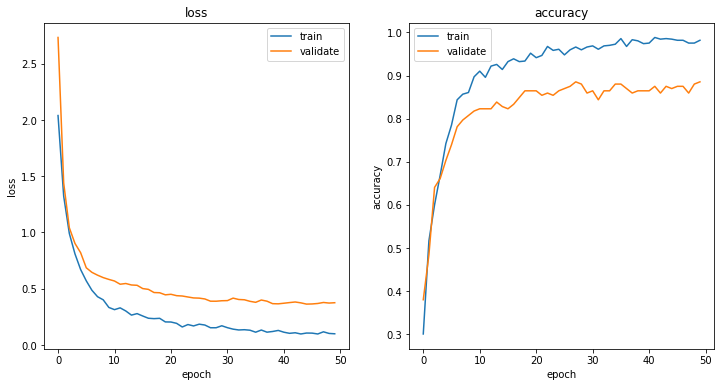

In [89]:
plot_history(history)

In [90]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 79.58% 
Test loss     = 0.541463


In [91]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0889 - accuracy: 0.9883 - val_loss: 0.3648 - val_accuracy: 0.8802
Epoch 2/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0986 - accuracy: 0.9883 - val_loss: 0.3532 - val_accuracy: 0.8802
Epoch 3/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0881 - accuracy: 0.9844 - val_loss: 0.3549 - val_accuracy: 0.8698
Epoch 4/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0907 - accuracy: 0.9831 - val_loss: 0.3544 - val_accuracy: 0.8698
Epoch 5/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0880 - accuracy: 0.9844 - val_loss: 0.3576 - val_accuracy: 0.8646
Epoch 6/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0845 - accuracy: 0.9870 - val_loss: 0.3464 - val_accuracy: 0.8698
Epoch 7/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0895 - accur

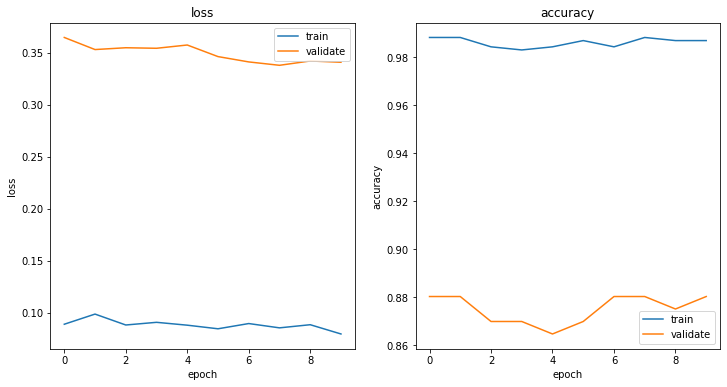

In [92]:
plot_history(history)

In [93]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 78.75% 
Test loss     = 0.528084


# Fine tune VGG16

In [94]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [95]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [96]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

14714688

In [97]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[15:18]:
   layer.trainable = True
    
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

7079424

In [0]:
vgg.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [99]:
vgg.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                401424    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16)                64        
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 68        
Total params: 15,116,244
Trainable params: 7,480,948
Non-trainable params: 7,635,296
___________________________________

In [100]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 6s 8ms/sample - loss: 0.0846 - accuracy: 0.9844 - val_loss: 0.3424 - val_accuracy: 0.8750
Epoch 2/10
768/768 [==============================] - 5s 7ms/sample - loss: 0.0887 - accuracy: 0.9844 - val_loss: 0.3313 - val_accuracy: 0.8906
Epoch 3/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0919 - accuracy: 0.9831 - val_loss: 0.3298 - val_accuracy: 0.8750
Epoch 4/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0817 - accuracy: 0.9883 - val_loss: 0.3220 - val_accuracy: 0.8906
Epoch 5/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0788 - accuracy: 0.9896 - val_loss: 0.3386 - val_accuracy: 0.9010
Epoch 6/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0815 - accuracy: 0.9831 - val_loss: 0.3353 - val_accuracy: 0.8698
Epoch 7/10
768/768 [==============================] - 5s 7ms/sample - loss: 0.0911 - accur

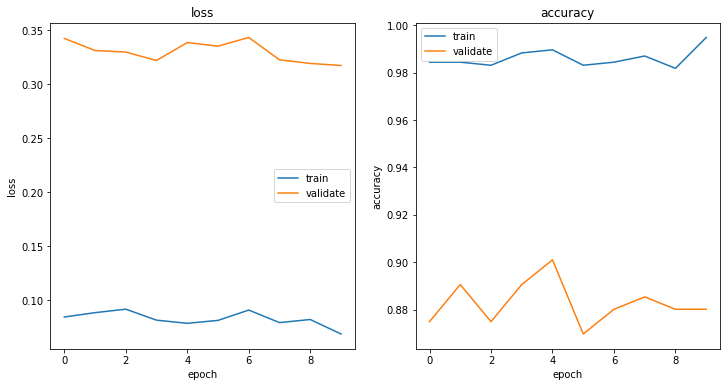

In [101]:
plot_history(history)

In [102]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/20
768/768 [==============================] - 5s 7ms/sample - loss: 0.0796 - accuracy: 0.9870 - val_loss: 0.3129 - val_accuracy: 0.8750
Epoch 2/20
768/768 [==============================] - 5s 6ms/sample - loss: 0.0835 - accuracy: 0.9896 - val_loss: 0.2946 - val_accuracy: 0.9062
Epoch 3/20
768/768 [==============================] - 5s 6ms/sample - loss: 0.0688 - accuracy: 0.9896 - val_loss: 0.2951 - val_accuracy: 0.9062
Epoch 4/20
768/768 [==============================] - 5s 7ms/sample - loss: 0.0779 - accuracy: 0.9883 - val_loss: 0.3043 - val_accuracy: 0.8958
Epoch 5/20
768/768 [==============================] - 5s 6ms/sample - loss: 0.0758 - accuracy: 0.9883 - val_loss: 0.2987 - val_accuracy: 0.8906
Epoch 6/20
768/768 [==============================] - 5s 6ms/sample - loss: 0.0700 - accuracy: 0.9883 - val_loss: 0.2864 - val_accuracy: 0.8802
Epoch 7/20
768/768 [==============================] - 5s 6ms/sample - loss: 0.0743 - accur

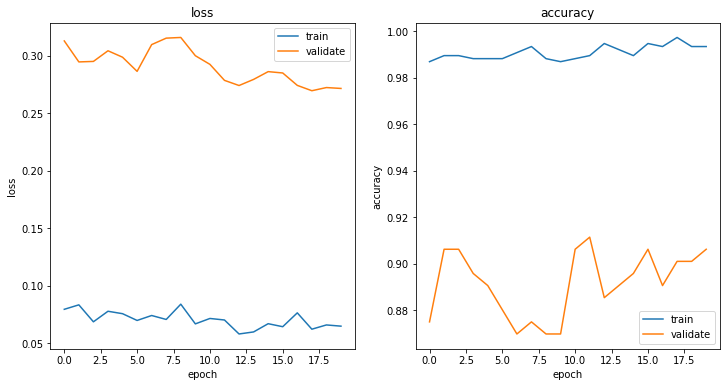

In [103]:
plot_history(history)

In [104]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 82.50% 
Test loss     = 0.403855


# VGG from scratch

In [0]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True

In [0]:
vgg_scratch = build_network(base_model)

In [0]:
vgg_scratch.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

In [108]:
history = vgg_scratch.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 17s 22ms/sample - loss: 1.8373 - accuracy: 0.3203 - val_loss: 5.6289 - val_accuracy: 0.3229
Epoch 2/10
768/768 [==============================] - 11s 15ms/sample - loss: 1.4169 - accuracy: 0.4062 - val_loss: 3.9084 - val_accuracy: 0.3385
Epoch 3/10
768/768 [==============================] - 11s 15ms/sample - loss: 1.2148 - accuracy: 0.4805 - val_loss: 17.3131 - val_accuracy: 0.3333
Epoch 4/10
768/768 [==============================] - 11s 15ms/sample - loss: 1.1202 - accuracy: 0.5534 - val_loss: 1.0096 - val_accuracy: 0.5938
Epoch 5/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.8627 - accuracy: 0.6628 - val_loss: 2.0332 - val_accuracy: 0.4635
Epoch 6/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.7153 - accuracy: 0.7148 - val_loss: 1.1006 - val_accuracy: 0.5885
Epoch 7/10
768/768 [==============================] - 11s 15ms/sample - loss:

In [109]:
history = vgg_scratch.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.4079 - accuracy: 0.9206 - val_loss: 0.6223 - val_accuracy: 0.7448
Epoch 2/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.4155 - accuracy: 0.9167 - val_loss: 0.6610 - val_accuracy: 0.7031
Epoch 3/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.3997 - accuracy: 0.9245 - val_loss: 0.4676 - val_accuracy: 0.9010
Epoch 4/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.3815 - accuracy: 0.9193 - val_loss: 0.4264 - val_accuracy: 0.8854
Epoch 5/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.3711 - accuracy: 0.9375 - val_loss: 0.3654 - val_accuracy: 0.9479
Epoch 6/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.3576 - accuracy: 0.9453 - val_loss: 0.4298 - val_accuracy: 0.9219
Epoch 7/10
768/768 [==============================] - 11s 15ms/sample - loss: 

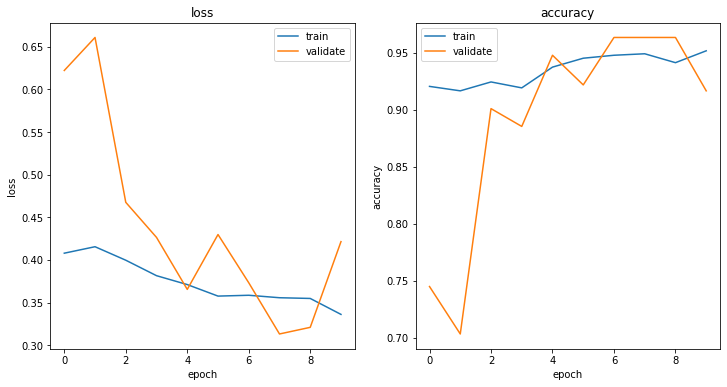

In [110]:
plot_history(history)

In [111]:
score = vgg_scratch.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 90.83% 
Test loss     = 0.420385


# Unseen data

In [0]:
def store_image(img_url, class_type):

  filename = ''
  response = requests.get(img_url)

  if response.status_code == 200:
    directory = 'car-dataset/train/{}'.format(class_type)
    os.chdir(directory)
    filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)

    with open('{}.jpg'.format(filename), 'wb') as f:
      f.write(response.content)

    os.chdir('../../..')

  return directory + '/{}.jpg'.format(filename)

In [0]:
def classify(img_url, class_type, **trained_model):
  
  filename = store_image(img_url, class_type)
  img = image.load_img(filename, target_size=(224, 224))

  plt.imshow(np.squeeze(img).astype('uint8'))

  img = image.img_to_array(img)
  img = resnet.preprocess_input(img)
  img = np.expand_dims(img, axis=0)

  for name, model in trained_model.items(): 
    golf = model.predict_classes(img)
    if (golf == 0):
      golf = '7.5'
    elif (golf == 1):
      golf = '7'
    elif (golf == 2):#se:
      golf = '6'
    else: 
      golf = 5
    print('Classifier:', name)
    print('Golf model:', golf, ', proba:', model.predict_proba(img), '\n')

### Golf 5

Classifier: vgg_model
Golf model: 5 , proba: [[0.10691524 0.37824252 0.05793868 0.45690364]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.04378008 0.06902699 0.08676016 0.8004328 ]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.07757336 0.57522696 0.17958765 0.16761209]] 



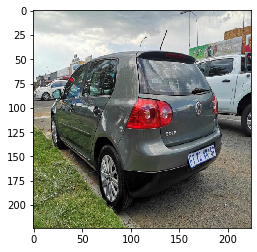

In [145]:
classify(
    'https://www.carmag.co.za/car-images/Gauteng/6091-648349_5/2007-Volkswagen-GOLF-5-GOLF-2.0-COMFORTLINE-5.jpeg',
    '5', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

### Golf 6

Classifier: vgg_model
Golf model: 6 , proba: [[5.4744788e-04 3.5007754e-03 9.9538827e-01 5.6354946e-04]] 

Classifier: resnet_model
Golf model: 6 , proba: [[5.2660273e-04 1.7908314e-03 9.9237263e-01 5.3100069e-03]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.03476963 0.04457218 0.90550566 0.01515247]] 



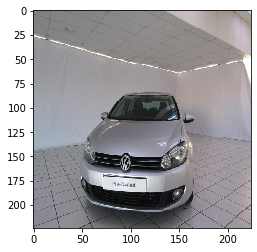

In [146]:
classify(
    'https://img.autotrader.co.za/3760195/Crop800x600',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[8.1094966e-04 3.1698819e-03 9.9526983e-01 7.4938918e-04]] 

Classifier: resnet_model
Golf model: 6 , proba: [[6.8939594e-04 3.2442443e-03 9.8922974e-01 6.8366262e-03]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.04614036 0.05701401 0.87486964 0.02197604]] 



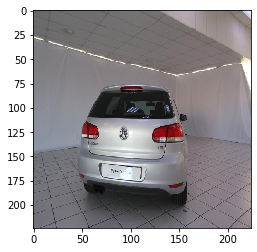

In [147]:
classify(
    'https://img.autotrader.co.za/3760198/Crop800x600',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.04687832 0.20204516 0.6989888  0.05208774]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.10132678 0.16280176 0.4511545  0.28471696]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.13979055 0.5256557  0.23607892 0.09847483]] 



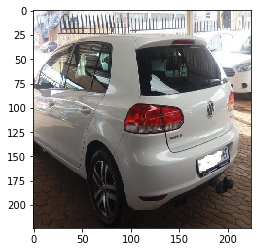

In [148]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_5.jpg?v=1868034972',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.07878642 0.20191215 0.685414   0.03388746]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02384616 0.07653192 0.80498147 0.0946405 ]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.05132443 0.47888756 0.3255462  0.14424185]] 



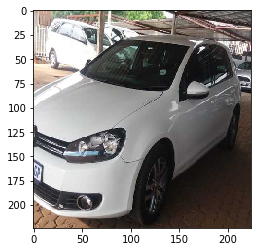

In [149]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351.jpg?v=1868034972',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.01775956 0.19935308 0.7574591  0.02542829]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.06603538 0.3345377  0.47073138 0.12869556]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.1696101  0.5228136  0.19476566 0.11281066]] 



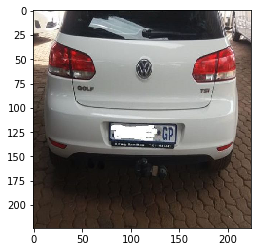

In [150]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_6.jpg?v=1868034972',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.01130165 0.22579873 0.75730234 0.00559717]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.05378849 0.25869223 0.6264445  0.06107477]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.03782783 0.53244954 0.3405117  0.08921089]] 



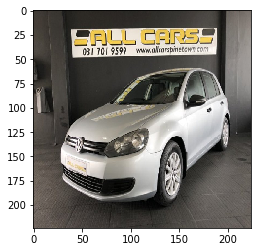

In [151]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964.jpg?v=125421204',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 7 , proba: [[0.04123781 0.77759    0.17994542 0.00122682]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.23060076 0.3311949  0.16543692 0.27276736]] 

Classifier: resnet_transfer_model
Golf model: 6 , proba: [[0.18254037 0.26393768 0.45651692 0.09700505]] 



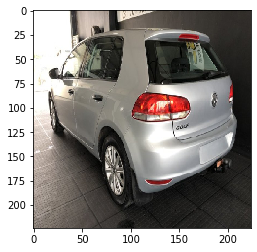

In [152]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964_3.jpg?v=125421204',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 7 , proba: [[0.12854753 0.6110585  0.08214998 0.17824398]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.24477203 0.38497525 0.06542563 0.30482712]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.05091131 0.61135316 0.11409803 0.22363758]] 



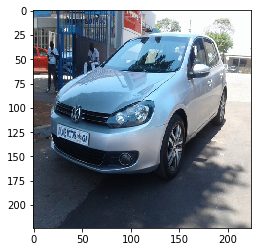

In [153]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.05616046 0.09628679 0.7719357  0.07561709]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.09003362 0.1280241  0.06910306 0.7128392 ]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.07680899 0.5008759  0.17109115 0.25122398]] 



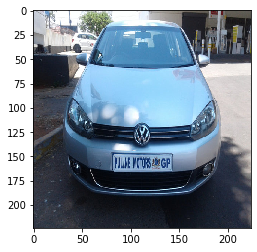

In [154]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_2.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.0401401  0.2327987  0.65288335 0.07417782]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.22000468 0.3248013  0.25836226 0.19683173]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.08725865 0.59374917 0.18903975 0.12995243]] 



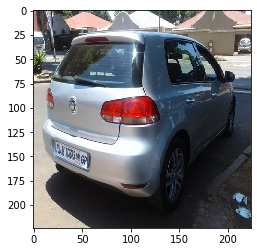

In [155]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_8.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 7 , proba: [[0.02352546 0.7335785  0.18009688 0.06279915]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.10854741 0.5575201  0.25800404 0.07592844]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.03231141 0.69046277 0.19804326 0.07918255]] 



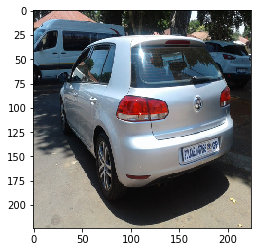

In [156]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_7.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.01211961 0.20890325 0.718011   0.06096614]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.02767622 0.5066425  0.38913047 0.07655083]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.0336585  0.7857975  0.13114774 0.04939625]] 



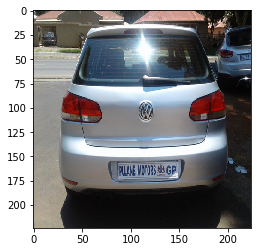

In [157]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_6.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 7 , proba: [[0.00320661 0.81264603 0.15150242 0.03264498]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.08210631 0.41143692 0.07707475 0.42938203]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.05695373 0.44711277 0.28809798 0.20783556]] 



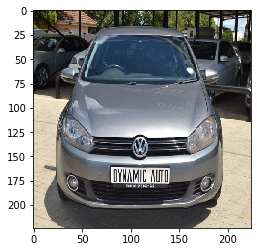

In [158]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5530306_2.jpg?v=4074465811',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

### Golf 7


Classifier: vgg_scratch
Golf model: 7.5 , proba: [[0.6601024  0.17146018 0.02315684 0.14528057]] 

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.43103516 0.05439204 0.26494923 0.2496236 ]] 

Classifier: resnet_model
Golf model: 7.5 , proba: [[0.32674608 0.30422625 0.0903296  0.27869803]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.34264854 0.3588535  0.1453785  0.15311944]] 



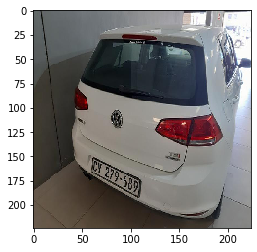

In [159]:
classify(
    'https://img.autotrader.co.za/4873898/Crop800x600',
    '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 7 , proba: [[0.30917045 0.46964362 0.0139886  0.20719737]] 

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.8115993  0.11849277 0.04802594 0.02188198]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.27876446 0.505746   0.11512056 0.10036896]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.4001276  0.41526392 0.12067597 0.06393249]] 



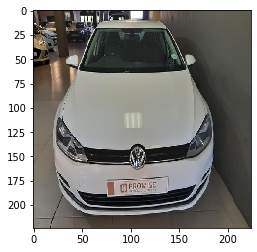

In [160]:
classify(
         'https://img.autotrader.co.za/4873896/Crop800x600',
         '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
         )

Classifier: vgg_scratch
Golf model: 7 , proba: [[0.09690866 0.79647523 0.02793658 0.0786795 ]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.16016412 0.25045198 0.50108093 0.08830298]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.3232474  0.4101303  0.07983246 0.18678989]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.25082347 0.588803   0.06521589 0.09515762]] 



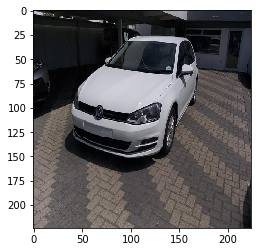

In [161]:
classify(
         'https://img.autotrader.co.za/5248234/Crop800x600',
         '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
         )


Classifier: vgg_scratch
Golf model: 7 , proba: [[0.12698694 0.66071707 0.016768   0.19552803]] 

Classifier: vgg_model
Golf model: 5 , proba: [[0.12387996 0.08890422 0.02624925 0.7609666 ]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.04401295 0.8844457  0.03240353 0.03913778]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.26625443 0.4900015  0.11382224 0.1299218 ]] 



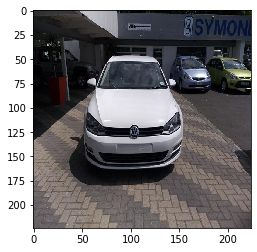

In [162]:
classify(
         'https://img.autotrader.co.za/5248233/Crop800x600',
         '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
         )

### Golf 7.5

Classifier: vgg_scratch
Golf model: 7.5 , proba: [[0.4969634  0.23940967 0.00921211 0.25441486]] 

Classifier: vgg_model
Golf model: 7 , proba: [[0.15618716 0.82578164 0.00227727 0.0157539 ]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.0667     0.9180874  0.00616288 0.00904967]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.08775782 0.81243473 0.05216306 0.04764437]] 



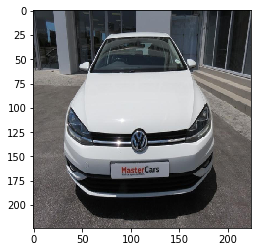

In [163]:
classify(
    'https://img.autotrader.co.za/4971489/Crop800x600',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 7 , proba: [[0.36601427 0.3998295  0.00844198 0.22571424]] 

Classifier: vgg_model
Golf model: 7 , proba: [[0.21176152 0.63794875 0.06407321 0.08621654]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.14510937 0.7404891  0.0413318  0.07306973]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.0850982  0.74975723 0.08689684 0.07824779]] 



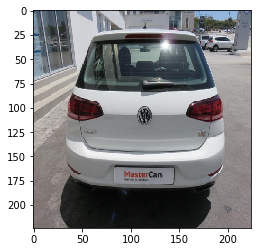

In [164]:
classify(
    'https://img.autotrader.co.za/4971493/Crop800x600',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 7.5 , proba: [[0.7795468  0.10651529 0.00826342 0.10567445]] 

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.68689466 0.08230215 0.0574023  0.1734009 ]] 

Classifier: resnet_model
Golf model: 5 , proba: [[0.17543069 0.05721632 0.04534396 0.7220091 ]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.26106468 0.4947964  0.1512789  0.09286   ]] 



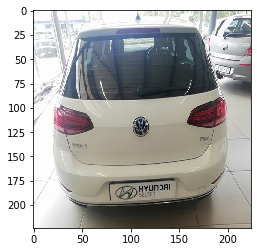

In [165]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_6.jpg?v=317154964',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 7.5 , proba: [[0.7279346  0.12404632 0.01432141 0.13369766]] 

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.8421476  0.07980742 0.06927083 0.00877416]] 

Classifier: resnet_model
Golf model: 7.5 , proba: [[0.6188219  0.35700843 0.00494751 0.01922221]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.5439665  0.27567065 0.08290478 0.09745818]] 



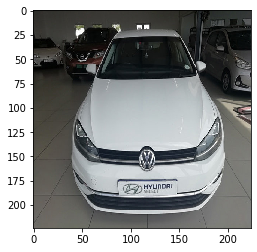

In [166]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_3.jpg?v=317154964',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 7.5 , proba: [[0.75460535 0.04024087 0.00941986 0.1957339 ]] 

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.7793816  0.1088472  0.00236086 0.10941035]] 

Classifier: resnet_model
Golf model: 7.5 , proba: [[0.55791706 0.22352794 0.04597405 0.17258094]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.21632682 0.6608373  0.0520835  0.07075231]] 



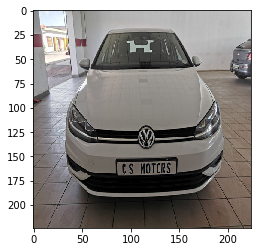

In [167]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_2.jpg?v=158700226',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 7.5 , proba: [[0.8043065  0.10100868 0.00435559 0.09032919]] 

Classifier: vgg_model
Golf model: 7 , proba: [[0.34376606 0.59944373 0.00745675 0.04933349]] 

Classifier: resnet_model
Golf model: 7 , proba: [[0.31906953 0.55655974 0.01567939 0.10869129]] 

Classifier: resnet_transfer_model
Golf model: 7 , proba: [[0.22781932 0.5539371  0.09865811 0.11958549]] 



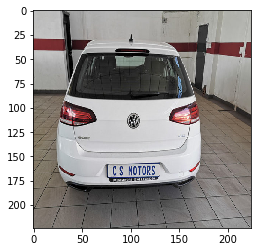

In [168]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_7.jpg?v=158700226',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

In [0]:
# 1. Change classify function to accept multiple models
# 2. Build simple network to count side/front/rear shots of each class
# 3. Investigate network ensemble